In [1]:
import zipfile as zip
with zip.ZipFile('/content/archive (2).zip','r') as f:
  f.extractall('/content/')

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np


In [7]:
generator = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Use the model's expected preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [8]:
train_images = generator.flow_from_directory(
    directory = "/content/Art",
    target_size = (224,224),
    batch_size = 32,
    subset = "training",
    class_mode = "binary",
    shuffle = True,
    seed = 42
)

val_data = generator.flow_from_directory(
    directory="/content/Art",
    target_size=(224, 224),
    batch_size=32,
    subset="validation", # Corrected: only use the validation subset
    class_mode="binary",
    shuffle=False
)

Found 777 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


In [6]:
base_model = MobileNetV2(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/tmp/ipython-input-1867868262.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, None,      │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, None,      │          0 │ bn_Conv1[0][0]    │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │          0 │ expanded_conv_de… │
│ (ReLU)              │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        512 │ expanded_conv_de… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, None,      │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, None,      │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, None,      │          0 │ block_1_expand_B… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, None,      │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, None,      │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, None,      │          0 │ block_1_depthwis… │
│ (ReLU)              │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, None,      │      2,304 │ block_1_depthwis

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 4/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6191 - loss: 1.3561

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.5887 - loss: 1.3964 - val_accuracy: 0.5751 - val_loss: 0.7997
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.6152 - loss: 0.6854 - val_accuracy: 0.6788 - val_loss: 0.6190
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.6870 - loss: 0.5759 - val_accuracy: 0.6632 - val_loss: 0.6420
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.7458 - loss: 0.5186 - val_accuracy: 0.7202 - val_loss: 0.5645
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7705 - loss: 0.4887 - val_accuracy: 0.7254 - val_loss: 0.5964
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7295 - loss: 0.5042 - val_accuracy: 0.7306 - val_loss: 0.5473
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.7591 - loss: 0.4804 - val_accuracy: 0.7047 - val_loss: 0.5482
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7965 - loss: 0.4362 - val_accuracy: 0.6839 - val_loss: 0.6212
Ep

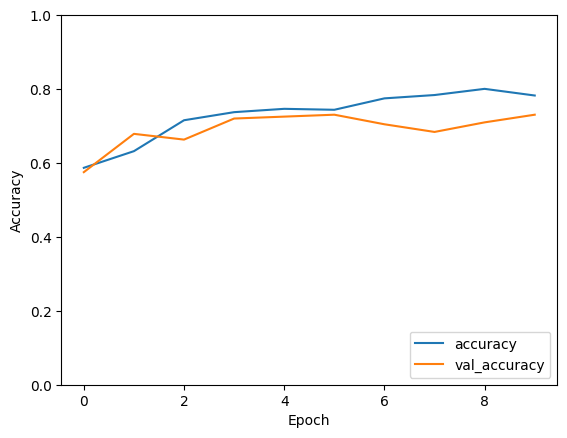

In [9]:
# Train the model
history = model.fit(
    train_images,
    validation_data=val_data,
    epochs=10
)

# Visualize training results
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step
Average Precision (AP): 0.75


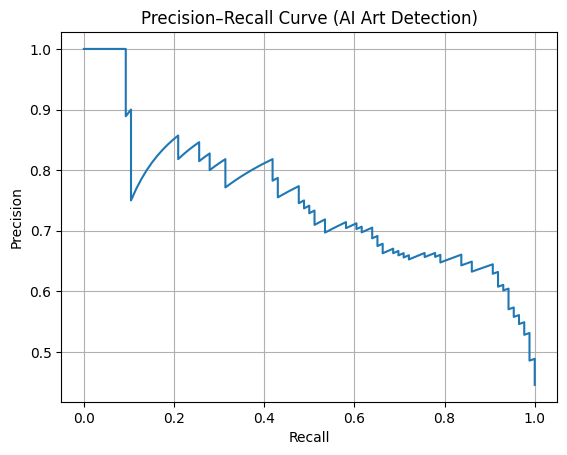

In [10]:
# Validation probabilities
y_true = val_data.classes                     # 0/1 labels
y_prob = model.predict(val_data).ravel()      # sigmoid outputs
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)
print("Average Precision (AP):", round(ap, 3))
import matplotlib.pyplot as plt

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (AI Art Detection)")
plt.grid(True)
plt.show()


In [11]:
print(thresholds)

[0.01233692 0.01465067 0.01718527 0.01829675 0.01964729 0.02052758
 0.02584659 0.02665695 0.02985267 0.03210565 0.04300816 0.04420032
 0.04511364 0.04615087 0.04938549 0.04959227 0.05472495 0.0574849
 0.05854023 0.06045549 0.06336811 0.06648856 0.06750946 0.07306842
 0.0767595  0.07746083 0.07915726 0.08055558 0.0829898  0.08750826
 0.09198868 0.09199244 0.09263292 0.09274761 0.10197002 0.10807469
 0.1122106  0.11271337 0.11667532 0.11933149 0.12420523 0.13220178
 0.1423125  0.14391848 0.1538637  0.15957683 0.1626421  0.16302502
 0.17098974 0.17224067 0.17315096 0.17362495 0.17376679 0.17527233
 0.18520048 0.19705652 0.19832332 0.20244086 0.20489554 0.20651676
 0.23430386 0.23497221 0.23559384 0.23574066 0.2390847  0.24389426
 0.2444434  0.25183183 0.25216788 0.2534039  0.25597125 0.2560653
 0.2571295  0.2580205  0.25892672 0.26128292 0.27224332 0.27403197
 0.274732   0.27752012 0.27891362 0.2860844  0.2887917  0.29844072
 0.31026325 0.31894153 0.3193893  0.32054895 0.32940295 0.330817

In [17]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Load the image and resize it to the target size used during training
    img = image.load_img(img_path, target_size=(224, 224))

    # Convert the image to a numpy array and add a batch dimension
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    plt.imshow(img)
    plt.show()
    # Apply the same preprocessing function used in the ImageDataGenerator
    img_array = preprocess_input(img_array)

    # Predict the probability
    prediction = model.predict(img_array)
    probability = prediction[0][0]

    # Determine the class name based on the class indices
    class_names = {v: k for k, v in train_images.class_indices.items()}
    predicted_label = class_names[1] if probability > 0.5 else class_names[0]

    print(f"Image: {img_path.split('/')[-1]}")
    print(f"Predicted Class: {predicted_label}")
    print(f"Probability Score: {probability:.4f}")

    return predicted_label, probability

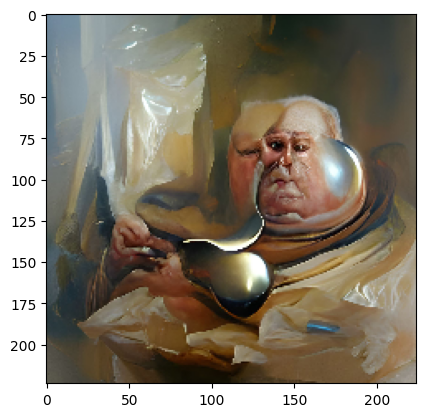

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Image: 07-the-coffee-service-hossaini-art-ai.x3e656121.png
Predicted Class: AiArtData
Probability Score: 0.0816


('AiArtData', np.float32(0.08158121))

In [19]:
predict_image("/content/Art/AiArtData/07-the-coffee-service-hossaini-art-ai.x3e656121.png")